In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import pyxalign.plotting.plotters as p
import pyxalign.api.options as opts
import numpy as np
from importlib import reload
import pyxalign
from pyxalign.dev_utils import reload_module_recursively
import copy
from pyxalign.io.loaders.xrf.api import load_data_from_xrf_format
from pyxalign.plotting.plotters import ImagePlotObject, make_image_slider_plot


In [2]:
# Load the XRF data
folder = "/net/micdata/data3/hruth/xrf_data/Tomo-3-new/"
xrf_standard_data_dict = load_data_from_xrf_format(folder)

100%|██████████| 93/93 [00:16<00:00,  5.66it/s]


In [3]:
# F = h5py.File(os.path.join(folder, '2xfm_0699.mda.h5'), "r")

In [4]:
# Convert the XRF data into a dictionary of arrays, where each
# dictionary key corresponds to a channel
from pyxalign.io.loaders.xrf.api import convert_xrf_projection_dicts_to_arrays
xrf_array_dict = convert_xrf_projection_dicts_to_arrays(
    xrf_standard_data_dict,
    pad_with_mode=True,
)

Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1114.59it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1098.22it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1175.59it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1092.49it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1131.06it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1143.86it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1086.58it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1163.44it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1149.08it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1167.31it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1168.44it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1180.20it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1168.13it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1156.45it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1175.34it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1176.03it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1174.67it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1176.86it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1118.59it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1086.08it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1158.21it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1098.20it/s]

Fixing projections dimensions...Completed


In [5]:
# Insert the data into an XRFTask object
from pyxalign.data_structures.xrf_object import XRFTask
# Just use angles from the first one
k = "Al"
xrf_task = XRFTask(
    xrf_array_dict=xrf_array_dict,
    angles=xrf_standard_data_dict[k].angles,
    scan_numbers=xrf_standard_data_dict[k].scan_numbers,
    task_options=opts.AlignmentTaskOptions(),
    projection_options=opts.ProjectionOptions(is_tomo=True),
    primary_channel="Total_Fluorescence_Yield",
)
# The primary_channel designates which channel of data is used in alignment calculations.
# This can be changed at any time.

100%|██████████| 10/10 [00:00<00:00, 40.62it/s]


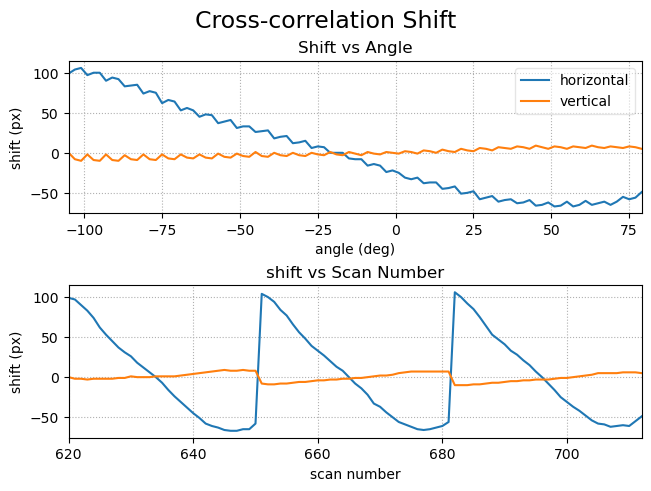

Cross-correlation shift stored in shift_manager


In [6]:
# Update cross-correlation options and run the alignment
xrf_task.task_options.cross_correlation = opts.CrossCorrelationOptions(
    iterations=10,
    binning=1,
    filter_data=0.01,
    remove_slow_variation=False,
    use_end_corrections=False,
)
xrf_task.get_cross_correlation_shift()

interactive(children=(IntSlider(value=0, description='index', max=92), Output()), _dom_classes=('widget-intera…

Play(value=0, description='Play', interval=500, max=92)

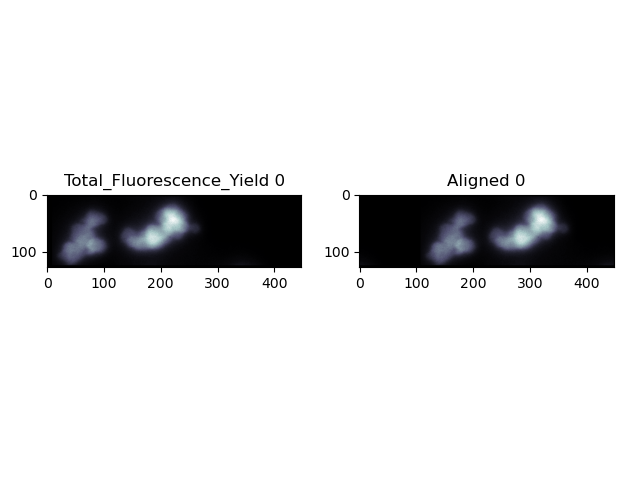

In [7]:
# Plot the results
%matplotlib widget
sort_idx = np.argsort(xrf_task.angles)
xrf_task.plot_alignment_results(["Total_Fluorescence_Yield"], sort_idx = sort_idx)

interactive(children=(IntSlider(value=0, description='index', max=92), Output()), _dom_classes=('widget-intera…

Play(value=0, description='Play', interval=500, max=92)

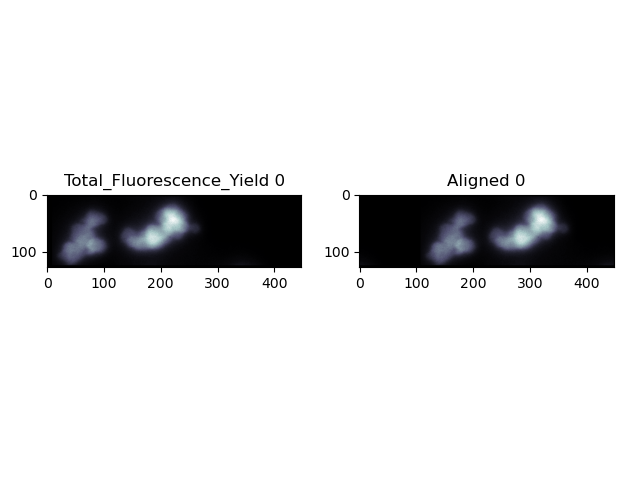

In [8]:
# Plot the results
%matplotlib widget
sort_idx = np.argsort(xrf_task.angles)
xrf_task.plot_alignment_results(["Total_Fluorescence_Yield"], sort_idx = sort_idx)

In [9]:
# Finally, apply the cross-correlation_shift
xrf_task.apply_staged_shift_to_all_channels()

In [10]:
print(list(xrf_task.channels))

['Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Ti', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'COMPTON_AMPLITUDE', 'COHERENT_SCT_AMPLITUDE', 'Num_Iter', 'Fit_Residual', 'Total_Fluorescence_Yield', 'Sum_Elastic_Inelastic']


interactive(children=(IntSlider(value=0, description='index', max=92), Output()), _dom_classes=('widget-intera…

Play(value=0, description='Play', interval=500, max=92)

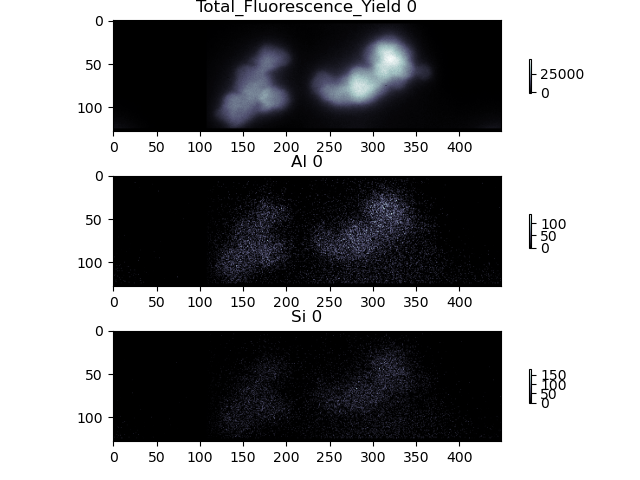

In [11]:
plot_options = opts.ImageSliderPlotOptions(image=opts.PlotDataOptions(colorbar=True))
xrf_task.plot_xrf_channels(
    channels=["Total_Fluorescence_Yield", "Al", "Si"],
    plot_options=plot_options,
    subplot_dims=(3, 1),
)

## get 3D reconstruction

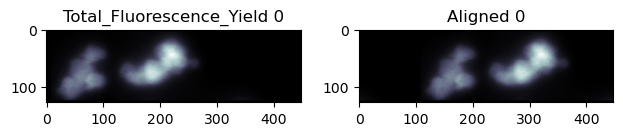

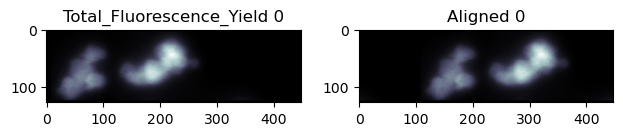

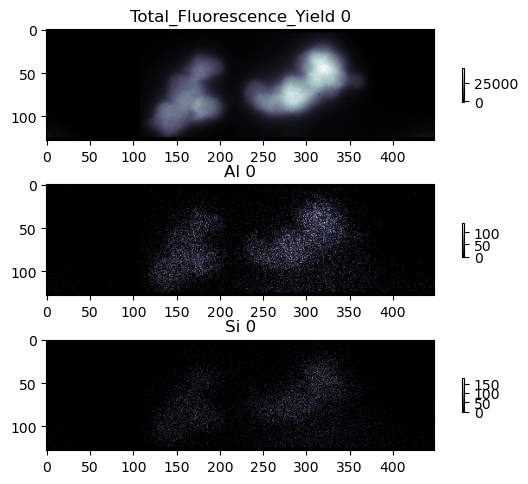

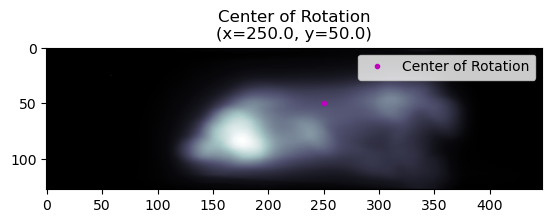

In [12]:
%matplotlib inline
xrf_task.projections_dict[xrf_task.primary_channel].center_of_rotation[1] = 250 # 240
xrf_task.projections_dict[xrf_task.primary_channel].center_of_rotation[0] = 50
plt.figure()
xrf_task.projections_dict[xrf_task.primary_channel].show_center_of_rotation()
plt.show()

In [13]:
xrf_task.projections_dict[xrf_task.primary_channel].options.experiment.sample_thickness = 250
xrf_task.projections_dict[xrf_task.primary_channel].options.experiment.laminography_angle = 90

In [14]:
xrf_task.projections_dict[xrf_task.primary_channel].reconstructed_object_dimensions 

array([896, 896, 250])

In [15]:
# xrf_task.projections_dict[xrf_task.primary_channel]._reconstructed_object_dimensions = np.array([317, 317, 250])

[896 896 250]


interactive(children=(IntSlider(value=0, description='index', max=249), Output()), _dom_classes=('widget-inter…

Play(value=0, description='Play', interval=500, max=249)

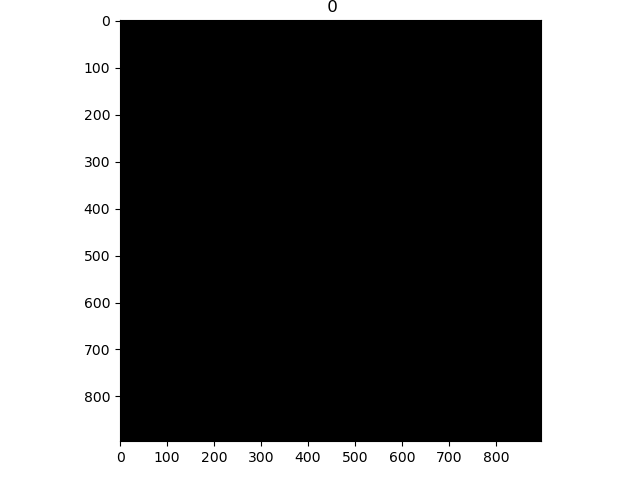

In [16]:
xrf_task.projections_dict[xrf_task.primary_channel].options.experiment.laminography_angle = 90
print(xrf_task.projections_dict[xrf_task.primary_channel].reconstructed_object_dimensions)

# pinned_data = pyxalign.gpu_utils.create_empty_pinned_array_like(
#     xrf_task.projections_dict[xrf_task.primary_channel].data
# )
xrf_task.projections_dict[xrf_task.primary_channel].get_3D_reconstruction()#True, pinned_data)

%matplotlib widget
clim = [0, 2.6e6]
# clim = [0, 500]
plot_options = opts.ImageSliderPlotOptions(slider=opts.SliderPlotOptions(), image=opts.PlotDataOptions(clim=clim))
plot_object = ImagePlotObject(
    xrf_task.projections_dict[xrf_task.primary_channel].laminogram.data, options=plot_options
)
make_image_slider_plot([plot_object])

In [17]:
xrf_task.projections_dict[xrf_task.primary_channel].laminogram.data.shape

(250, 896, 896)

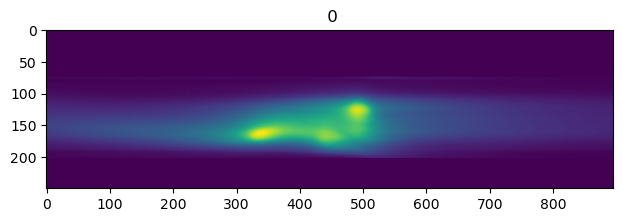

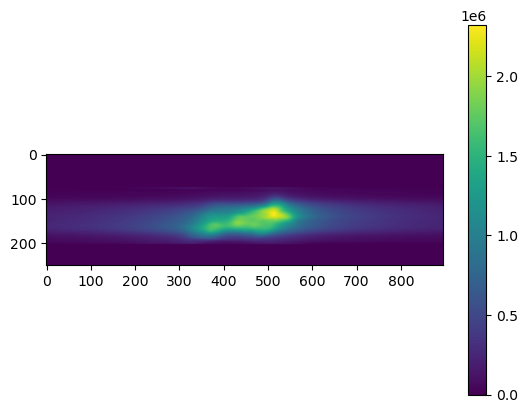

In [18]:
%matplotlib inline
plt.imshow(xrf_task.projections_dict[xrf_task.primary_channel].laminogram.data[:, :, 400])
plt.show()
plt.imshow(xrf_task.projections_dict[xrf_task.primary_channel].laminogram.data[:, 400])
plt.colorbar()
plt.show()

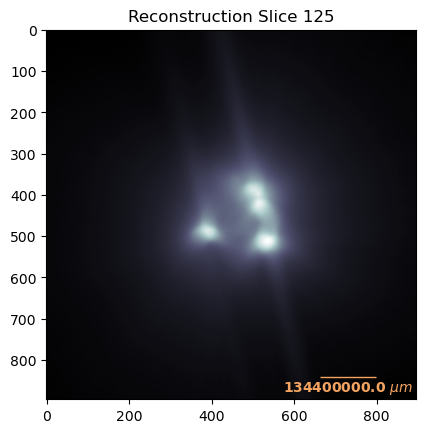

In [19]:
%matplotlib inline
xrf_task.projections_dict[xrf_task.primary_channel].laminogram.plot_data()

In [25]:
300

300

In [30]:
xrf_task.projections_dict[xrf_task._primary_channel].data.shape

(93, 128, 448)

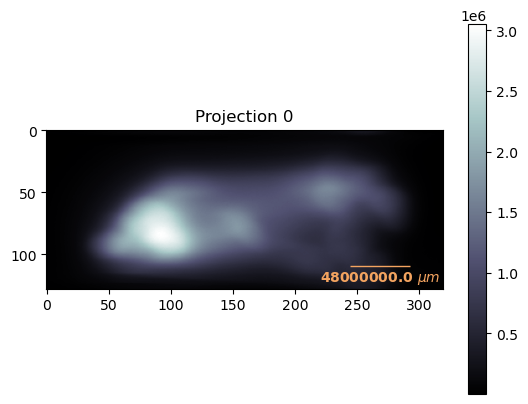

In [31]:
# show crop
from pyxalign.plotting.plotters import plot_slice_of_3D_array
crop_options = opts.CropOptions(enabled=True, horizontal_range=320, horizontal_offset=20)
xrf_task.projections_dict[xrf_task._primary_channel].plot_data(
    opts.PlotDataOptions(crop=crop_options, clim=None),
    plot_sum=True,
    show_plot=False,
)
plt.colorbar()
plt.show()

In [32]:
# crop projections
xrf_task.projections_dict[xrf_task._primary_channel].crop_projections(crop_options)

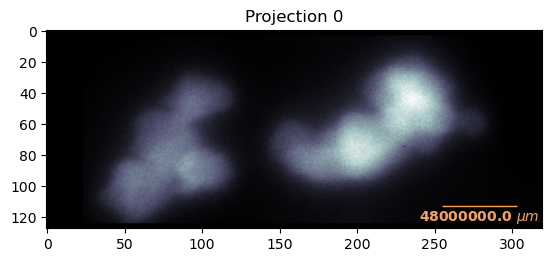

In [33]:
# pad projections vertically
xrf_task.projections_dict[xrf_task._primary_channel].plot_data()

In [ ]:
xrf_task.projections_dict[xrf_task.primary_channel].get_3D_reconstruction()#True, pinned_data)

%matplotlib widget
clim = [0, 2.6e6]
# clim = [0, 500]
plot_options = opts.ImageSliderPlotOptions(slider=opts.SliderPlotOptions(), image=opts.PlotDataOptions(clim=clim))
plot_object = ImagePlotObject(
    xrf_task.projections_dict[xrf_task.primary_channel].laminogram.data, options=plot_options
)
make_image_slider_plot([plot_object])

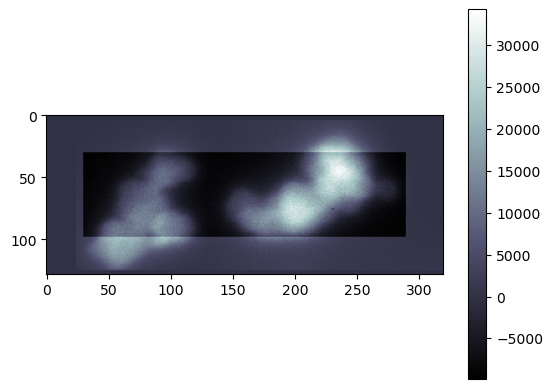

In [40]:
# generate dummy mask
%matplotlib inline
dummy_mask = np.zeros_like(xrf_task.projections_dict[xrf_task._primary_channel].data)
dummy_mask[:, 30:-30, 30:-30] = 1

plt.imshow(xrf_task.projections_dict[xrf_task._primary_channel].data[0]-10000*dummy_mask[0], cmap="bone")
plt.colorbar()
plt.show()

xrf_task.projections_dict[xrf_task._primary_channel].masks = dummy_mask

In [ ]:
plt.imshow(
    xrf_task.projections_dict[xrf_task._primary_channel].data[sort_idx[0]]
    - xrf_task.projections_dict[xrf_task._primary_channel].data[sort_idx[i]],
    cmap="bone",
)

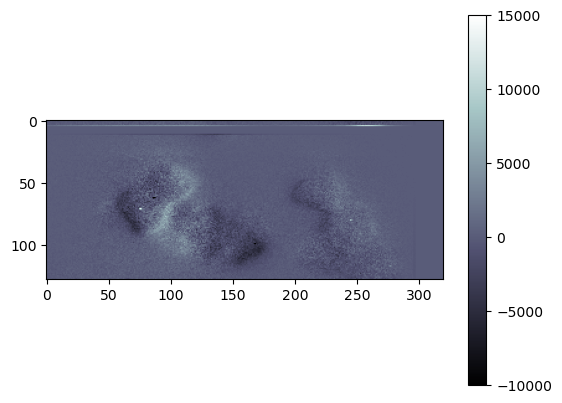

In [62]:
i = -2
plt.imshow(
    xrf_task.projections_dict[xrf_task._primary_channel].data[sort_idx[i - 1]]
    - xrf_task.projections_dict[xrf_task._primary_channel].data[sort_idx[i]],
    cmap="bone",
)
plt.colorbar()
plt.clim([-10000, 15000])


In [41]:
xrf_task.projections_dict[xrf_task._primary_channel].pin_arrays()

In [42]:
# self.pma_object.aligned_projections.laminogram.clear_astra_objects()
from pyxalign.alignment.projection_matching import ProjectionMatchingAligner


In [64]:
xrf_task.angles[0] - xrf_task.angles[-1]

-184.0

In [44]:
xrf_task.projections_dict[xrf_task._primary_channel]

In [45]:
pma_options = xrf_task.task_options.projection_matching
pma_options.keep_on_gpu = True
pma_options.high_pass_filter = 0.0000000000005
pma_options.min_step_size = 1e-6
pma_options.iterations = 10
pma_options.plot.update.stride = 1
pma_options.plot.update.enabled = True
pma_options.downsample.scale = 2
pma_options.downsample.enabled = True
pma_options.downsample.use_gaussian_filter = True

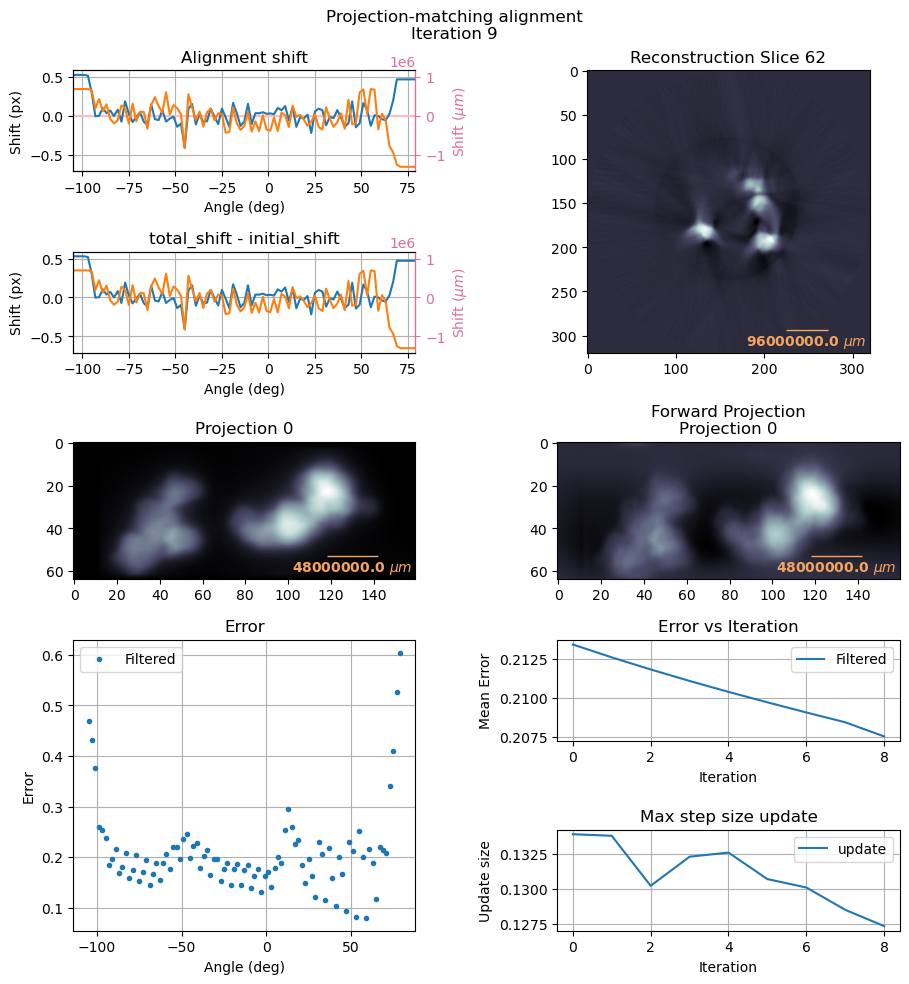

projection matching loop: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]

Max step size update: 0.1267 px


In [46]:
pma_object = ProjectionMatchingAligner(
    xrf_task.projections_dict[xrf_task._primary_channel], pma_options
)
shift = pma_object.run()

xrf_task.projections_dict[xrf_task._primary_channel].shift_manager.stage_shift(
    shift=shift,
    function_type="fft",
    alignment_options=pma_options,
)


In [43]:
xrf_task.projections_dict[xrf_task._primary_channel].reconstructed_object_dimensions

array([600, 600, 250])

In [41]:
from pyxalign import LaminographyAlignmentTask


task = LaminographyAlignmentTask(
    phase_projections=xrf_task.projections_dict[xrf_task._primary_channel],
    options=xrf_task.task_options,
)
task.save_task(
    os.path.join("/net/micdata/data3/hruth/xrf_data/", "Tomo-3-new_results", "xcorr_task.h5")
)


projections saved to /net/micdata/data3/hruth/xrf_data/Tomo-3-new_results/xcorr_task.h5/phase_projections
task saved to /net/micdata/data3/hruth/xrf_data/Tomo-3-new_results/xcorr_task.h5/


interactive(children=(IntSlider(value=0, description='index', max=92), Output()), _dom_classes=('widget-intera…

Play(value=0, description='Play', interval=500, max=92)

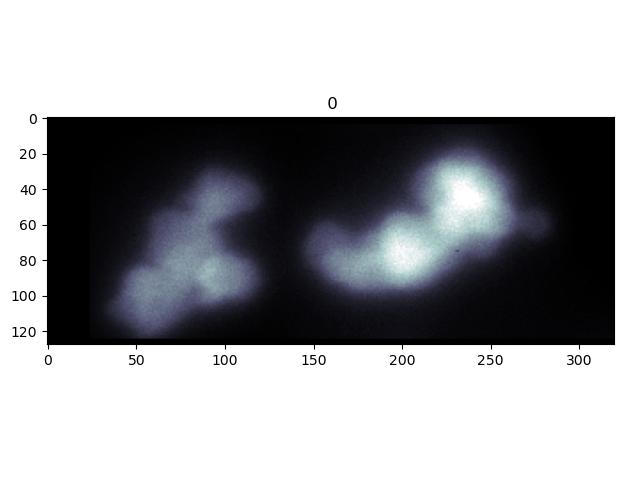

In [65]:
%matplotlib widget
# clim = [0, 2.6e6]
clim = [0, 40000]
plot_options = opts.ImageSliderPlotOptions(
    slider=opts.SliderPlotOptions(), image=opts.PlotDataOptions(clim=clim)
)
plot_object = ImagePlotObject(
    xrf_task.projections_dict[xrf_task.primary_channel].data[sort_idx], options=plot_options
)
make_image_slider_plot([plot_object])


## you can also drop projections

In [ ]:
xrf_task.drop_projections_from_all_channels(remove_idx=[95, 96, 97, 98])

In [1]:
plot_options = opts.ImageSliderPlotOptions(image=opts.PlotDataOptions(colorbar=True))
xrf_task.plot_xrf_channels(
    channels=["Total_Fluorescence_Yield", "Al", "Si"],
    plot_options=plot_options,
    subplot_dims=(3, 1),
)

NameError: name 'opts' is not defined